# House with a garage 
## Stenzel Jeroen and Bienz Moritz
### Date 2020.11.20

**Objectives:**
- Modelling a two room system
- Analyse a System with two rooms, where one is heatet

**Contents:**
- description of the building
- thermal cuircit 
- thermal conductences
- thermal capacitys
- system of algebraic-differential equations (DAE)
- state-space reprecentation
- steady-state 
- dynamic simulation
- weather simulation


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem


## Physical analysis

### Description of the building

![Abgabe](./figures/00_Groundfloor.png)
> Figure 1. floorplan house with a garage

### The dimensions and surface areas of the building are:

In [2]:
#dimentions [m]
l1 = 5       #length of garage
l2 = 4
breite = 6       #width of garage
hight = 2.5     #hight of garage
S1wall = 2 * l1 * hight
S1window = breite * hight
S1floor = l1 * breite
S1roof = l1 * breite
S2wall = breite * hight + l2 * hight
S2door = l2 * hight
S2floor = l2 * breite
S2roof = l2 * breite
S12 = breite * hight
Va1 = l1 * breite * hight
Va2 = l2 * breite * hight

### Thermo-physical properties
The thermophysical properties of the air (in SI units) are:

In [3]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


The [thermophysical properties](https://energieplus-lesite.be/donnees/enveloppe44/enveloppe2/conductivite-thermique-des-materiaux/) and the surface areas of the different materials (i.e., concrete, insulation, wood, glass) in SI units are:

In [4]:
wall = {'Conductivity': [1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 0.027, 0.027, 0.027, 0.16, 1.4, 1.5, 1.5],  # W/(m·K)
        'Density': [2300, 2300, 2300, 2300, 2300, 2300, 2300, 55, 55, 55, 600, 2500, 1500, 1500],        # kg/m³
        'Specific heat': [880, 880, 880, 880, 880, 880, 880, 1210, 1210, 1210, 1760, 750, 1000, 1000], # J/(kg·K)
        'Width': [0.20, 0.20, .20, 0.20, 0.20, .20, 0.20, 0.08, 0.08, 0.08, 0.05, 0.01, 1, 1],         # m
        'Surface': [S1wall, S1roof, S1floor, S2wall, S2roof, S2floor, S12, S1wall, S1roof, S12, S2door, S1window, S1floor, S2floor],      # m²
        'Slices': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}                # number of  slices
wall = pd.DataFrame(wall, index=['Concrete1w', 'Concrete1r', 'Concrete1f', 'Concrete2w', 'Concrete2r', 'Concrete2f', 'Concrete12', 'Insulation1w', 'Insulation1r', 'Insulation12','Wood', 'Glass', 'Ground1', 'Ground2'])
wall

,Conductivity,Density,Specific heat,Width,Surface,Slices
Concrete1w,1.400,2300,880,0.20,25.0,1
Concrete1r,1.400,2300,880,0.20,30.0,1
Concrete1f,1.400,2300,880,0.20,30.0,1
Concrete2w,1.400,2300,880,0.20,25.0,1
Concrete2r,1.400,2300,880,0.20,24.0,1
Concrete2f,1.400,2300,880,0.20,24.0,1
Concrete12,1.400,2300,880,0.20,15.0,1
Insulation1w,0.027,55,1210,0.08,25.0,1
Insulation1r,0.027,55,1210,0.08,30.0,1
Insulation12,0.027,55,1210,0.08,15.0,1


The [radiative properties](https://en.wikipedia.org/wiki/Emissivity#Absorptivity) of the surfaces are:
- short wave [absortivity of solar radiation](https://www.engineeringtoolbox.com/solar-radiation-absorbed-materials-d_1568.html) of white smooth surfaces;
- short wave [transmittance](https://www.engineeringtoolbox.com/optical-properties-glazing-materials-d_1355.html) of window glass (thickness of 4 mm);
- short wave [absortivity and transmittance](https://energieplus-lesite.be/techniques/enveloppe7/composants-de-l-enveloppe/vitrages/vitrage-permettant-le-controle-solaire/) of reflective blue window glass.

In [5]:
α_c = 0.25    # short wave absortivity: concrete
α_w = 0.4    # short wave absortivity: wood
α_g = 0.38    # short wave absortivity: reflective blue glass
τ_g = 0.30    # short wave transmitance: reflective blue glass

The [Stefan-Boltzmann constant](https://en.m.wikipedia.org/wiki/Stefan–Boltzmann_constant) is:

In [6]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant


Conventional values for the [convection coeficients](https://energieplus-lesite.be/theories/enveloppe9/echanges-chaleur-parois/resistance-thermique-d-echange-superficiel/) for indoor and outdoor convection in W/(m²⋅K) are:

In [7]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
h

,in,out
h,8.0,25


## Thermal circuit

Heat transfert is:
- through the walls (concrete and insulation), 
- through the glass window,
- through the walls (concrete)
- through the door (wood)
- through the ground (concrete - earth)
- from the HVAC system.

The HVAC system is modelled as a proportional controller. There is long wave radiative exchange between the wall and the glass window. The sources are:
- temperature sources:
    - outdoor atmospheric air;
    - indoor air temperature setpoint;
- flow rate sources:
    - solar radiation on the outdoor and the indoor walls;
    - auxiliary heat gains in the thermal zone.

![thermal_circuit](./figures/01_System.png)
> Figure 2. Thermal circuit for the system.

Figure 2 shows the models of:
- concrete in grey
- isolation in green
- glass window: in blue;
- Door in brown (dark)
- Ground in orange (medium)
- HVAC in orange (bright)
- Room 1 in violett
- Room 2 in yellow

The sources are:
- $T_o$ - outdoor temperature, °C;
- $T_{i,sp}$ - setpoint temperaure for the indoor air, °C;
- $T_{ground}$ - ground temperature , °C;
- $\Phi_1$ - solar radiation absorbed by the outdoor surface of the wall_1, W;
- $\Phi_2$ - solar radiation absorbed by the indoor surface of the wall_1, W;
- $\Phi_3$ - solar radiation absorbed by the outdoor surface of the roof_1, W;
- $\Phi_4$ - solar radiation absorbed by the indoor surface of the roof_1, W;
- $\Phi_5$ - solar radiation absorbed by the indoor surface of the ground_1, W;
- $\Phi_6$ - solar radiation absorbed by the outdoor surface of the wall_1, W;
- $\Phi_7$ - solar radiation absorbed by the outdoor surface of the roof_1, W;

*Note*: The known values, i.e. the elements of the circuit (the conductances $G$ and capacities $C$) and the sources (of temperature $T$ and of flow rate $\Phi$ or $\dot{Q}$) are noted in uppercase (majuscule) letters. The unknow variables, i.e. the temperatures in the nodes $\theta$ and the flow rates on the branches $q$, are noted in lowercase (minuscule) letters.

### Thermal coductances
#### Conduction
The conductances 2, 3, 4, 5, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 22, 23, 26, 27, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40 and 0, 20 of the thermal circuit from Figure 2 Thermal circuit for the system. Conduction conductances, in W/K, are of the form:
$$G_{cd} = \frac{\lambda}{w}S$$
where:

- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), W/(m⋅K);
- $w$ - width of the material, m;
- $S$ - surface area of the wall, m².

In [8]:
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance'})

,Conductance
Concrete1w,175.0000
Concrete1r,210.0000
Concrete1f,210.0000
Concrete2w,175.0000
Concrete2r,168.0000
Concrete2f,168.0000
Concrete12,105.0000
Insulation1w,8.4375
Insulation1r,10.1250
Insulation12,5.0625


#### Convection
The conductances 1, 6, 7, 12, 19, 21, 24, 25, 28, 35, 36, 41 model the heat transfer by [convection](https://en.m.wikipedia.org/wiki/Convection_(heat_transfer). Convection conductances, in W/K, are of the form:
$$G_{cv} = {h S}$$
where:
- $h$ is the [convection coefficient](https://en.m.wikipedia.org/wiki/Heat_transfer_coefficient), W/(m²⋅K);
- $S$ - surface area of the wall, m². 

In [9]:
# Convection
G1wall = h * wall['Surface'][0]     # wall
G1roof = h * wall['Surface'][1]
G1floor = h * wall['Surface'][2]
G2wall = h * wall['Surface'][3]
G2roof = h * wall['Surface'][4]
G2floor = h * wall['Surface'][5]
G12 = h * wall['Surface'][6]
G1window = h * wall['Surface'][11]  
G2door = h * wall['Surface'][10]  


In [10]:
# glass: convection outdoor & conduction
Ggs = float(1 / (1 / G1window['out'] + 1 / (2 * G_cd['Glass'])))
# door: convection outdoor & conduction
Gdr = float(1 / (1 / G2door['out'] + 1 / (2 * G_cd['Wood'])))

#### Proportional controller

In the simplest representation, the [HVAC system](https://en.m.wikipedia.org/wiki/HVAC_control_system) can be considered as a [proportional controller](https://en.m.wikipedia.org/wiki/Proportional_control) that adjusts the heat flow rate $q_{HVAC}$ in order to control the indoor temperature $\theta_i$ at its setpoint value $T_{i,sp}$. The heat flow-rate, in W, injected by the [HVAC](https://en.m.wikipedia.org/wiki/Heating,_ventilation,_and_air_conditioning) system into the controlled space is:

$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

where:
- $K_p$ is the proportional gain, W/K;
- $T_{i, sp}$ - indoor temperature [setpoint](https://en.m.wikipedia.org/wiki/Setpoint_(control_system)), °C (noted in majuscule because it is an *input, i.e. independent, variable*);
- $\theta_i$ - indoor temperature, °C (noted in minuscule because it is a *output, i.e. dependent variable*).

This equation shows that the proportional controller can be modelled by a source of temperature, $T_{i, sp}$, and a conductance, $K_p$. If the controller gain tends to:
- infinity, $K_p \rightarrow \infty$, then the control is perfect, $\theta_i \rightarrow T_{i, sp}$.
- zero, $K_p \rightarrow 0$, then the controller is not acting and the building is in free-running, i.e. $q_{HVAC} = 0$ ([Ghiaus 2003](https://doi.org/10.1016/S0378-7788(02)00110-X)).

*Note*: Respecting the [sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention#Active_and_passive_components), the flow rate $q_{HVAC}$ is oriented from the lower to the higher potential of the temperature source $T_{i,sp}$.

In [11]:
# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
#Kp = 1e-3           # no controller Kp -> 0
#Kp = 0

### Thermal capacities
#### Walls
The [thermal capacities](https://en.m.wikipedia.org/wiki/Heat_capacity) of the wall, in J/kg, are of the form:

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

where:
- $m_w = \rho_w w_w S_w$ is the mass of the wall, kg;
- $c_w$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity), J/(kg⋅K);
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density), kg/m³;
- $w_w$ - width of the wall, m;
- $S_w$ - surface area of the wall, m².

In [12]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']

#### Air
Similarly, the thermal capacity of the air, in J/kg, is:

$$C_a = m_a c_a = \rho_a c_a V_a$$

where:
- $m_a = \rho_a V_a$ is the mass of the air, kg;
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density) of air, kg/m³;
- $c_a$ - specific heat capacity of the air, J/(kg⋅K);
- $V_a$ - volume of the air in the thermal zone, m³.

In [13]:
C['Air1'] = air['Density'] * air['Specific heat'] * Va1
C['Air2'] = air['Density'] * air['Specific heat'] * Va2
pd.DataFrame(C, columns={'Capacity'})

,Capacity
Concrete1w,10120000.0
Concrete1r,12144000.0
Concrete1f,12144000.0
Concrete2w,10120000.0
Concrete2r,9715200.0
Concrete2f,9715200.0
Concrete12,6072000.0
Insulation1w,133100.0
Insulation1r,159720.0
Insulation12,79860.0


### Temperature sources

The [temperature sources](https://en.m.wikipedia.org/wiki/Voltage_source#Ideal_voltage_sources) model temperatures which vary independently of what happens in the themal circuit; they are inputs of the physical model. Generally, the temperature sources are:
- outdoor air and ground temperature;
- temperature of adjacent spaces which have controlled temperature;
- setpoint temperature.

#### Outdoor air and ground temperature
The hourly values of outdoor temperatures can be obtained from weather data files downloadable from the [Repository of free climate data for building performance simulation](http://climate.onebuilding.org) or from [Weather data for EnergyPlus®](https://energyplus.net/weather) (see the tutorial on [Weather data and solar radiation](01WeatherData.ipynb)).

#### Adjacent spaces with controlled temperature

If the adjacent spaces are controlled by a HVAC system, it means that their temperature can be considered independent of the studied thermal zone(s); therefore, they can be modelled by a temperature source.

#### Setpoint temperature

[Setpoint](https://en.m.wikipedia.org/wiki/Setpoint_(control_system)) temperatures do not depend on the heat transfer processes of the analyzed thermal zone(s). If the HVAC system can deliver the heat flow rate:

$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

where:
- $K_p$ is the proportional gain, W/K;
- $T_{i, sp}$ - indoor temperature [setpoint](https://en.m.wikipedia.org/wiki/Setpoint_(control_system)), °C;
- $\theta_i$ - indoor temperature, °C,

then the setpoint for indoor temperature, $T_{i, sp}$, may be modelled by a source of temperature.

### Heat flow rate sources
The [heat flow rate sources](https://en.m.wikipedia.org/wiki/Current_source#Background) model flow rates which vary idependently of what happens in the themal circuit. They are inputs of the physical model. Generally, the heat flow rate sources are:
- solar radiation absorbed by the walls;

#### Solar radiation absorbed by the walls

The [direct](https://en.m.wikipedia.org/wiki/Direct_insolation), diffuse and reflected components of the [solar radiation](https://en.m.wikipedia.org/wiki/Solar_irradiance) on a tilted surface can be estimated from weather data by using the function `sol_rad_tilt_surf` from the module `dm4bem` (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

##### External wall

The radiation absorbed by the outdoor surface of the wall is:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:
- $\alpha_{w,SW}$ is the [absorptance](https://en.m.wikipedia.org/wiki/Absorptance) of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total [solar irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on the wall, W/m².

## System of algebraic-differential equations (DAE)

The analysis of a thermal circuit, or the direct problem ([Ghiaus 2022](https://hal.archives-ouvertes.fr/hal-03484064/document)), means to find the temperatures in the nodes, $\theta$, and the heat flows on the branches, $q$, i.e. to solve for $\theta$ and $q$ the system of [Differential-Algebraic Equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations) (Figures 3 and 4):

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

where:
- $\theta$ is the temperature vector of size $n_\theta$ equal to the number of nodes;
- $q$ - heat flow vector of size $n_q$ equal to the number of branches;
- $A$ - [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of size $n_q$ rows and $n_{\theta}$ columns, where $n_q$ is the number of flow branches and $n_{\theta}$  is the number of temperature nodes. It shows how the temperature nodes are connected by oriented branches of heat flows:
    - if flow *m* enters into node *n*, then the element (*m, n*) of the matrix $A$ is 1, i.e., $A_{m,n} = 1$;
    - if flow *m* exits from node *n*, then the element (*m, n*) of the matrix $A$ is -1, i.e., $A_{m,n} = -1$, ; 
    - if flow *m* is not connected to node *n*, then the element (*m, n*) of the matrix $A$ is 0, i.e., $A_{m,n} = 0$.

- $G$ - conductance diagonal matrix of size $n_q \times n_q$,  where $n_q$ is the number of flow branches: diagonal matrix containing the conductances. Each branch $k$ needs to contain a conductance $0 < G_{k,k} < \infty $. 

- $C$ - capacity diagonal matrix of size $n_θ \times n_θ$,  where $n_θ$ is the number of temperature nodes: diagonal matrix containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

- $b$ - temperature source vector of size $n_q$: if there is no temperature source on the branch *m*, then $b_m = 0$.

- $f$ - heat flow source vector of size $n_θ$: if there is no heat flow source in the node *n*, then $f_n = 0$.

The resolution is first done for temperatures, $\theta$, by solving the equation
$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
which, generally, is a system of differential-algebraic equations (DAE). Then, the heat flow rates are found from the equation
$$q = G (-A \theta + b)$$


### A: incidence matrix

The [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of the thermal circuit shown in Figure 2 is:

In [14]:
A = np.zeros([43, 35])       # n° of branches X n° of nodes
A[0, 16] = 1                 # branch 0: -> node 16
A[1, 0] = 1                 # branch 1: -> node 0
A[2, 0], A[2, 1] = -1, 1    # branch 2: node 0 -> node 1
A[3, 1], A[3, 2] = -1, 1    # branch 3: node 1 -> node 2
A[4, 2], A[4, 3] = -1, 1    # etc.
A[5, 3], A[5, 4] = -1, 1
A[6, 4], A[6, 16] = -1, 1
A[7, 5] = 1                 
A[8, 5], A[8, 6] = -1, 1    
A[9, 6], A[9, 7] = -1, 1    
A[10, 7], A[10, 8] = -1, 1
A[11, 8], A[11, 9] = -1, 1
A[12, 9], A[12, 16] = -1, 1
A[13, 10] = 1                 
A[14, 10], A[14, 11] = -1, 1    
A[15, 11], A[15, 12] = -1, 1    
A[16, 12], A[16, 13] = -1, 1
A[17, 13], A[17, 14] = -1, 1
A[18, 14], A[18, 15] = -1, 1
A[19, 15], A[19, 16] = -1, 1  
A[20, 29] = 1    
A[21, 17] = 1  
A[22, 17], A[22, 18] = -1, 1
A[23, 18], A[23, 19] = -1, 1
A[24, 19], A[24, 29] = -1, 1
A[25, 20] = 1  
A[26, 20], A[26, 21] = -1, 1
A[27, 21], A[27, 22] = -1, 1
A[28, 22], A[28, 29] = -1, 1
A[29, 23] = 1
A[30, 23], A[30, 24] = -1, 1
A[31, 24], A[31, 25] = -1, 1
A[32, 25], A[32, 26] = -1, 1
A[33, 26], A[33, 27] = -1, 1
A[34, 27], A[34, 28] = -1, 1
A[35, 28], A[35, 29] = -1, 1
A[36, 16], A[36, 30] = -1, 1
A[37, 31], A[37, 31] = -1, 1
A[38, 31], A[38, 32] = -1, 1
A[39, 32], A[39, 33] = -1, 1
A[40, 33], A[40, 34] = -1, 1
A[41, 34], A[41, 29] = -1, 1
A[42, 16] = 1
np.set_printoptions(suppress=False)
pd.DataFrame(A)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### G: conductance matrix

The conductance matrix of the themal circuit shown in Figure 2 is:

In [15]:
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance'})

# Convection
G1wall = h * wall['Surface'][0]     # wall
G1roof = h * wall['Surface'][1]
G1floor = h * wall['Surface'][2]
G2wall = h * wall['Surface'][3]
G2roof = h * wall['Surface'][4]
G2floor = h * wall['Surface'][5]
G12 = h * wall['Surface'][6]
G1window = h * wall['Surface'][11]  
G2door = h * wall['Surface'][10]  

# glass: convection outdoor & conduction
Ggs = float(1 / (1 / G1window['out'] + 1 / (2 * G_cd['Glass'])))
# door: convection outdoor & conduction
Gdr = float(1 / (1 / G2door['out'] + 1 / (2 * G_cd['Wood'])))


G = np.diag([Ggs, G1wall.iloc[0]['out'], 2 * G_cd['Insulation1w'], 2 * G_cd['Insulation1w'],
             2 * G_cd['Concrete1w'], 2 * G_cd['Concrete1w'], G1wall.iloc[0]['in'],   # Window and Wall1
             G1roof.iloc[0]['out'], 2 * G_cd['Insulation1r'], 2 * G_cd['Insulation1r'],
             2 * G_cd['Concrete1r'], 2 * G_cd['Concrete1r'], G1roof.iloc[0]['in'],   # Roof1
             G_cd['Ground1'], G_cd['Ground1'], G_cd['Ground1'], G_cd['Ground1'],
             2 * G_cd['Concrete1f'], 2 * G_cd['Concrete1f'], G1floor.iloc[0]['in'],   # Floor1
             Gdr, G2wall.iloc[0]['out'],  2 * G_cd['Concrete2w'], 2 * G_cd['Concrete2w'],
             G2wall.iloc[0]['in'],   # Door and Wall2
             G2roof.iloc[0]['out'],  2 * G_cd['Concrete2r'], 2 * G_cd['Concrete2r'], G2roof.iloc[0]['in'],   # Roof2
             G_cd['Ground2'], G_cd['Ground2'], G_cd['Ground2'], G_cd['Ground2'],
             2 * G_cd['Concrete2f'], 2 * G_cd['Concrete2f'], G2floor.iloc[0]['in'],   # Floor2
             G12.iloc[0]['in'], 2 * G_cd['Concrete12'], 2 * G_cd['Concrete12'],
             2 * G_cd['Insulation12'], 2 * G_cd['Insulation12'], G12.iloc[0]['out'],  # in and out changed due to direktions of flow in conetiong wall
             Kp])   # Controll System
np.set_printoptions(precision=3, threshold=16, suppress=True)
pd.set_option("display.precision", 1)
pd.DataFrame(G)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,344.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,625.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,16.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,16.9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,350.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,350.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,200.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,750.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### C: capacity matrix

The capacity matrix of the themal circuit shown in Figure 2 is:

With putting the small capacitys, such as air, to zero the timesteps would be larger. 

In [16]:
C = np.diag([0, C['Insulation1w'], 0, C['Concrete1w'], 0, 0, C['Insulation1r'],
              0, C['Concrete1r'], 0, C['Ground1'], C['Ground1'], C['Ground1'], 0,
              C['Concrete1f'], 0, C['Air1'],   #Room1
              0, C['Concrete2w'], 0, 0, C['Concrete2r'], 0, C['Ground2'],
              C['Ground2'], C['Ground2'], 0, C['Concrete2f'], 0, C['Air2'],   #Room2
              0, C['Concrete12'], 0, C['Insulation12'], 0])   #Wall12

pd.set_option("display.precision", 3)
pd.DataFrame(C)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.000e+00,0.0,...,0.000e+00,0.0,0.000e+00,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0
1,0.0,133100.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.000e+00,0.0,...,0.000e+00,0.0,0.000e+00,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.000e+00,0.0,...,0.000e+00,0.0,0.000e+00,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0
3,0.0,0.0,0.0,1.012e+07,0.0,0.0,0.0,0.0,0.000e+00,0.0,...,0.000e+00,0.0,0.000e+00,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.000e+00,0.0,...,0.000e+00,0.0,0.000e+00,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0
5,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.000e+00,0.0,...,0.000e+00,0.0,0.000e+00,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0
6,0.0,0.0,0.0,0.000e+00,0.0,0.0,159720.0,0.0,0.000e+00,0.0,...,0.000e+00,0.0,0.000e+00,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0
7,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.000e+00,0.0,...,0.000e+00,0.0,0.000e+00,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0
8,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,1.214e+07,0.0,...,0.000e+00,0.0,0.000e+00,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0
9,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.000e+00,0.0,...,0.000e+00,0.0,0.000e+00,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0


### b: temperature source vector

The vector of *temperature sources* is $b$, of size $n_q$, the number of branches (in this example 12). An element of the vector $b$ corresponding to a branch without a source is zero. If the flow in a source is from the low potential to the high potential of the source (i.e. from - to +), then the source is positive. If the flow rate in the temperature source is from high potential to low potential (i.e. from + to -), then the source is negative (see [passive sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention)). 

For the thermal circuit shown in Figure 2,



i.e. $b_0 = b_1 = b_{20} = b_{21} = b_{25} = b_{42} = T_o$

$b_{13} = b_{29} = T_{ground}$

$b_{42} = T_{i,sp}$ 

where:
- $T_o$ is the outdoor temperature, °C;
- $T_{ground}$ is the ground temperature, °C;
- $T_{i,sp}$ - set-point temperaure for the indoor air, °C.

Since the temperature sorces $T_o$,$T_{ground}$ and $T_{i,sp}$ are [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $b$ the branches which contain temperature sources are designated by $1$ and the branches without any temeprature source by $0$.

In [17]:
# Uncomment nex line to put all capacities to zero (steady state)
# C = np.zeros([34, 34])

b = np.zeros(43)        # branches
b[[0, 1, 7, 13, 20, 21, 25, 29, 42]] = 1   # branches with temperature sources
# print(f'b = ', b)
# Branches 13 and 29 are the ground temperature and branch 42 is the HVAC temperature

### f: heat flow source vector

The vector of *heat sources* is $f$, of size $n_{\theta}$, the number of nodes (in this example 8). An element of the vector $f$ corresponding to a node without a heat source is zero.

For the thermal circuit shown in Figure 2,

i.e. $f_0 = \Phi_1$, $f_4 = \Phi_2$, $f_5 = \Phi_3$, $f_9 = \Phi_4$, $f_{15} = \Phi_{5}$, $f_{17} = \Phi_{6}$, $f_{20} = \Phi_{7}$, where:
- $\Phi_{1}$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_{2}$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\Phi_{3}$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_{4}$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\Phi_{5}$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\Phi_{6}$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_{7}$ - solar radiation absorbed by the outdoor surface of the wall, W;



Since the flow rate sorces $\Phi_1$, $\Phi_2$, $\Phi_3$, $\Phi_4$, $\Phi_5$, $\Phi_6$ and $\Phi_7$ are [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $f$ the nodes which contain flow rate sources are designated by $1$ and the  nodes without any flow rate source by $0$. Exept $\Phi_2$, $\Phi_4$ and $\Phi_5$ from the indoor surface are also set $0$, because we assume no radiation on them.

In [18]:
f = np.zeros(35)        # nodes
f[[0, 5, 17, 20]] = 1     # nodes with heat-flow sources
# print(f'f = ', f)
# Nodes 4, 9 and 15 could also have a heat-flow source but are set to zero



### y: output vector

The vector of outputs is $y$, of size $n_{\theta}$, the number of nodes. The non-zero values of $y$ indicate the nodes which are the outputs of the model.

For the thermal circuit shown in Figure 2, if the output is the indoor air temperature from both rooms, then the output vector is:

In vector $y$, the nodes for which the temperatures are outputs are noted by $1$ and the other nodes by $0$.

In [19]:
y = np.zeros(35)         # nodes
y[[16, 29]] = 1              # nodes (temperatures) of interest
# print(f'y = ', y)
# Both rooms have their own output

## State-space representation
The [differential-algebraic system of equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)):

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_C + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

where- $\theta_s$ is the vector of state variables which are the temperatures of nodes containing capacities; the elements are in the same order as in the vector of temperatures, $\theta$; its dimension, $\dim \theta_s$, is equal to the number of capacities from the thermal network; for the circuit presented in Figure 2, $\theta_s = [\theta_1, \theta_3, \theta_6, \theta_7]^T$;

- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ - vector of inputs of dimension $\dim u$ equal to the number of sources (of temperaure and heat flows) of the thermal network, where:

    - vector $b_T$ of nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, $b_T = [T_o, T_o, T_o, T_{i,sp}]^T$ corresponds to branches 0, 8, 10 and 11; 
    - vector $f_Q$ of nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$ corresponds to nodes 0, 4, 6, and 7;
    
- $y$ - vector of outputs is a subset of vector $\theta$ representing temperature nodes which are of interest; for the circuit presented in Figure 3, $y = \theta_6$, the indoor temperature.

- $A_s$ - state matrix, of dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$;

- $B_s$ - input matrix, of dimension $\dim B_s = \dim {\theta_s} \times \dim u$;

- $C_s$ - output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_s}$;

- $D_s$ - feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.

*Note*: The subscript $s$ of the matrices $A_s, B_s, C_s, D_s$ is used to differentiante the matrices $A_s, C_s$ of the state-space represenation of the matrices $A, C$ of the system of DAE.

The [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation), i.e., matrices $A_s, B_s, C_s, D_s$ is obtained from the system of DAE, i.e., matrices and vectors $A, G, b, C, f, y$ ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)).

In [20]:
'''state space representation'''
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
# print('As = \n', As, '\n')
# print('Bs = \n', Bs, '\n')
# print('Cs = \n', Cs, '\n')
# print('Ds = \n', Ds, '\n')

## Steady-state

In [steady-state](https://en.m.wikipedia.org/wiki/Steady_state), the model can be checked if it is incorrect. Let's consider that:
- the controller is not active, $K_p \rightarrow 0$,
- the outdoor temperature is $T_o = 10 \, \mathrm{^\circ C}$,
- the ground temperature is $T_{ground} = 12 \, \mathrm{^\circ C}$,
- the indoor temperature setpoint is $T_{i,sp} = 20 \, \mathrm{^\circ C}$,
- all flow rate sources are zero.

In [21]:
'''steady state'''
b = np.zeros(43)                # temperature sources
b[[0, 1, 7, 20, 21, 25]] = 10   # outdoor temperature
b[[13, 29]] = 12                 # ground temperature
b[[42]] = 20                    # indoor set-point temperature

# Uncomment next lines to put 'Air' capacities to zero
# C = np.diag([0, C['Insulation1w'], 0, C['Concrete1w'], 0, 0, C['Insulation1r'],
#               0, C['Concrete1r'], 0, C['Ground1'], C['Ground1'], C['Ground1'], 0,
#               C['Concrete1f'], 0, 0,   #Room1
#               0, C['Concrete2w'], 0, 0, C['Concrete2r'], 0, C['Ground2'],
#               C['Ground2'], C['Ground2'], 0, C['Concrete2f'], 0, 0,   #Room2
#               0, C['Concrete12'], 0, C['Insulation12'], 0])   #Wall12

f = np.zeros(35)                # flow-rate sources

*Note*: Steady-state analysis is a test of [falsification (refutability)](https://en.m.wikipedia.org/wiki/Falsifiability) of the model, not of its correctness. If the model does not pass the steady-state test, it means that it is wrong. If the model passes the steady-state test, it does not mean that it is correct. For example, the values of the capacities in matrix $C$ or of the conductances in matrix $G$ can be wrong even when the steady-state test is passed. 

### System of Diferential Algebraic Equations (DAE)
The value of temperature in [steady-state](https://en.m.wikipedia.org/wiki/Steady_state) is obtained from the system of DAE by considering $\dot{\theta} = 0$:

$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$


In [22]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [10.118 14.486 18.854 ...  0.448  5.091  9.734] °C


### State-space representation
The input vector $u$ is obtained by stacking the vectors $b_T$ and $f_Q$:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- $b_T$ is a vector of the nonzero elements of vector $b$ of temperature sources. For the circuit presented in Figure 2, $b_T = [T_o, T_o, T_o, T_{ground},T_{o},T_{o},T_{o}, T_{ground}, T_{i,sp}]^T$ corresponding to branches 0, 1, 7, 13, 20, 21, 25, 29 and 42 where:
    - $T_o$ - outdoor temperature, °C;
    - $T_{ground}$ - ground temperature, °C;
    - $T_{i,sp}$ - set-point temperaure for the indoor air, °C.
- $f_Q$ - vector the nonzero elements of vector $f$ of flow sources. For the circuit presented in Figure 2, $f_Q = [\Phi_1, \Phi_5, \Phi_6, \Phi_7]^T$ corresponding to nodes 0, 3, 17, and 20, where:
    - $\Phi_1$ - solar radiation absorbed by the outdoor surface of the wall, W;
    - $\Phi_5$ - solar radiation absorbed by the outdoor surface of the wall, W;
    - $\Phi_6$ - solar radiation absorbed by the outdoor surface of the wall, W;
    - $\Phi_7$ - solar radiation absorbed by the outdoor surface of the wall, W;

*Note*: zero in vectors $b$ and $f$ indicates that there is no source on the branch or in the node, respectively. However, a source can have the value zero.

In [23]:
bT = np.array([10, 10, 10, 12, 10, 10, 10, 12, 20])     # [To, To, To, Tearth, To, To, To, Tearth, Tisp]
fQ = np.array([0, 0, 0, 0])         # [1, 5, 6, 7]
u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [10 10 10 12 10 10 10 12 20  0  0  0  0]


The steady-state value of the output of the state-space representation is:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [24]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

yss = [19.644  9.86 ] °C


The error between the steady-state values obtained from the system of DAE, $\theta_6$, and the output of the state-space representation, $y_{ss}$, 

$$\varepsilon = \left | \theta_6 - y_{ss} \right |$$

is practically zero; the slight difference is due to [numerical errors](https://en.m.wikipedia.org/wiki/Numerical_error).

In [25]:
print(f'Max error between DAE and state-space: \
{max(abs(θ[6] - yss)):.2e} °C')

Max error between DAE and state-space: 5.16e+00 °C


## Dynamic simulation

### Time step

The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

i.e. in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition [becomes](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)

$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = \min -2 / \lambda_i = \min 2 T_i$$

where $T_i$ are the [time constants](https://en.m.wikipedia.org/wiki/Time_constant), $T_i = - \frac{1}{\lambda_i} $

In [26]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = min(-2. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants: 
 [      8.351    4077.714    4077.695 ... 2105616.481  301519.573
  556532.277] s 

2 x Time constants: 
 [     16.702    8155.428    8155.389 ... 4211232.963  603039.145
 1113064.553] s 

Maximum time step: 16.70 s = 0.28 min


Let's chose a time step smaller than $\Delta t_{max} = \min -2 / \lambda_i $.

With the short time steps and the long setteling time of the system, the calculations would be to precise and would take to long. For this reason a longer dt was chosen. this means that the explicit euler is no longer viable to get the step response. it would lead to errors. so only the implicit euler was used with these larger time steps.

In [27]:
dt = 3600     # seconds
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 3600 s = 60 min


### Settling time
The [settling time](https://en.m.wikipedia.org/wiki/Step_response) is roughly 4 times the larger time constant.

In [28]:
t_resp = 4 * max(-1 / λ)
print('Time constants: \n', -1 / λ, 's \n')
print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
= {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

Time constants: 
 [      8.351    4077.714    4077.695 ... 2105616.481  301519.573
  556532.277] s 

Settling time: 8422466 s = 140374.4 min = 2339.57 h = 97.48 days


### Step response
Let's obtain the dynamic response of the system to a [step input](https://en.m.wikipedia.org/wiki/Step_response).

#### Duration
The duration of the simulation needs to be larger than the estimated [settling time](https://en.m.wikipedia.org/wiki/Settling_time). This requires a corresponding number of time steps in the time vector. 
In the following step resonse, the duration was shortened. The final value of the system is still almost reached at 99% but a longer duration would mean that the start of the step response would not be recognisable in the diagramm

In [29]:
'''Step response'''
#change the duration to get shorter graphs with an 9...% certainty
duration = 3600 * 24 * 10            # seconds, larger than response time
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
pd.DataFrame(t, columns=['time'])

Duration = 864000 s
Number of time steps = 240


,time
0,0
1,3600
2,7200
3,10800
4,14400
...,...
235,846000
236,849600
237,853200
238,856800


#### Input vector
In dynamic simulation, the inputs are [time series](https://en.m.wikipedia.org/wiki/Time_series), e.g., the oudoor temperature will have $n$ values $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.

The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$ of the system of Differential Algebraic Equations:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- vector $b_T$ consists of the nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 2, 

b

and 
$$b_T = [T_o, T_o, T_o, T_{ground}, T_o, T_o, T_o , T_{ground}, T_{i,sp}]^T$$
corresponding to branches 0, 8, 10 and 11; 
- vector $f_Q$ is the nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 2,

f 

and

$$f_Q = [\Phi_1, \Phi_5, \Phi_6, \Phi_7]^T$$

corresponding to nodes 1, 5, 6, and 7.

For the thermal circuit shown in Figure 3, the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the input vector, $u = [u_0, u_1, ... , u_{n-1}]^T$, is:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{ground}\\ 
T_o\\ 
T_o\\ 
T_o\\ 
T_{ground}\\ 
T_{i,sp}\\ 
\Phi_1\\ 
\Phi_5\\ 
\Phi_6\\ 
\Phi_7\\ 
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{ground(0)} & T_{ground(1)}& ... & T_{ground(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{ground(0)} & T_{ground(1)}& ... & T_{ground(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{1,(0)} & \Phi_{1,(1)} & ... & \Phi_{1,(n-1)}\\
\Phi_{5,(0)} & \Phi_{5,(1)} & ... & \Phi_{5,(n-1)}\\ 
 \Phi_{6(0)} & \Phi_{6(1)} & ... & \Phi_{6(n-1)}\\ 
\Phi_{7,(0)} & \Phi_{7,(1)} & ... & \Phi_{7,(n-1)}
\end{bmatrix}$$

where:



- $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the oudoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $T_{ground} = [T_{ground(0)}, T_{ground(1)}, ..., T_{ground(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the ground temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $T_{i, sp} = [T_{{i, sp}(0)}, T_{{i, sp}(1)}, ..., T_{{i, sp}(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the setpoint indoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_1 = [\Phi_{1(0)}, \Phi_{1(1)}, ..., \Phi_{1(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the outdoor surface of the wall at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_5 = [\Phi_{5(0)}, \Phi_{5(1)}, ..., \Phi_{5(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the outdoor surface of the wall at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_6 = [\Phi_{6(0)}, \Phi_{6(1)}, ..., \Phi_{6(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the outdoor surface of the wall at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_7 = [\Phi_{7(0)}, \Phi_{7(1)}, ..., \Phi_{7(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the outdoor surface of the wall at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.

Let's consider a step response in the conditions used for steady-state analysis, i.e. $T_o = 10 \, \mathrm{^\circ C}$, $T_{i,sp} = 20 \, \mathrm{^\circ C}$, and all the flow sources zero.

In [30]:
'''Input vector'''
u = np.zeros([13, n])                # u = [To, To, To, Tearth, To, To, To, Tearth, Thvac, t, t, t, t]
u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
u[3, :] = 12 * np.ones([1, n])      # Tearth = 12 for n time steps
u[4:7, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
u[7, :] = 12 * np.ones([1, n])      # Tearth = 12 for n time steps
u[8, :] = 20 * np.ones([1, n])      # Thvac = 20 for n time steps
print('u = ')
pd.DataFrame(u)

u = 


,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
4,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
5,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
6,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
7,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
8,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Time integration

By integrating the state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

In [31]:
'''Time integration'''
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    # θ_exp[:, k + 1] = (I + dt * As) @\
    #     θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])
        #calculate explicit only with short timesteps otherwise there is instability

we obtain the outputs

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively.

In [32]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

The results of explicit and implicit Euler integration are practically identical.

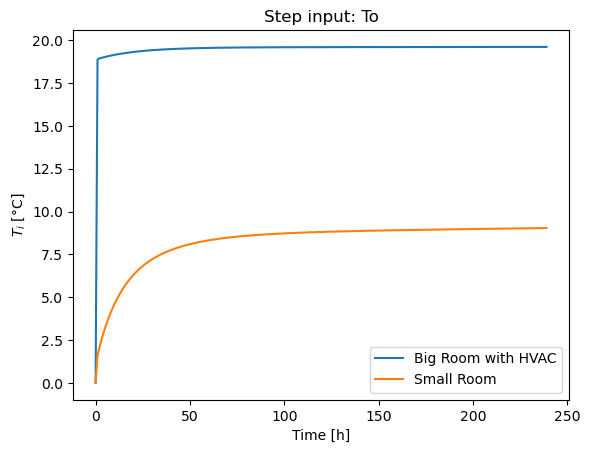

In [33]:
fig, ax = plt.subplots()
ax.plot( t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To')
ax.legend(['Big Room with HVAC', 'Small Room']) # we still gotta adjust the legend for both rooms
plt.show()

> Figure 3. Step response to outdoor temperature by using Euler
[implicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method)
and
[explicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration.

The value the indoor temperature obtained after the [settling time](https://en.m.wikipedia.org/wiki/Settling_time) is almost equal to the value obtained in steady-state.

In [34]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[16]):.4f} °C for Room 1 and {float(θ[29]):.4f} °C for Room 2')
print(f'- state-space model: yss = {yss} °C for rooms 1 and 2 to respectively')
print(f'- steady-state response to step input: {y_imp[0,-1]:.4f} °C for Room 1 and {y_imp[1,-1]:.4f} °C for Room 2')

Steady-state indoor temperature obtained with:
- DAE model: 19.6440 °C for Room 1 and 9.8596 °C for Room 2
- state-space model: yss = [19.644  9.86 ] °C for rooms 1 and 2 to respectively
- steady-state response to step input: 19.6108 °C for Room 1 and 9.0390 °C for Room 2


# Weather data

Define Start and End Date

In [35]:
start_date = '2000-01-03 12:00:00'
end_date = '2000-02-05 18:00:00'

print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-01-03 12:00:00 	start date
2000-02-05 18:00:00 	end date


Used Weatherdate is from Stuttgart (Germany)

In [36]:
filename = './weather_data/DEU_Stuttgart.107380_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(
    weather.index >= start_date) & (
    weather.index < end_date)]



pd.DataFrame(weather)

,temp_air,dir_n_rad,dif_h_rad
2000-01-03 12:00:00+01:00,7.6,356,132
2000-01-03 13:00:00+01:00,8.7,342,122
2000-01-03 14:00:00+01:00,8.0,459,66
2000-01-03 15:00:00+01:00,6.7,33,49
2000-01-03 16:00:00+01:00,5.6,0,8
...,...,...,...
2000-02-05 13:00:00+01:00,9.6,22,163
2000-02-05 14:00:00+01:00,8.7,0,74
2000-02-05 15:00:00+01:00,8.7,0,47
2000-02-05 16:00:00+01:00,7.8,0,16


In [37]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
pd.DataFrame(rad_surf)

rad_surf['Etot'] = rad_surf.sum(axis=1)

data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
pd.DataFrame(data)

,To,Etot
2000-01-03 12:00:00+01:00,7.6,439.477
2000-01-03 13:00:00+01:00,8.7,392.111
2000-01-03 14:00:00+01:00,8.0,400.798
2000-01-03 15:00:00+01:00,6.7,54.450
2000-01-03 16:00:00+01:00,5.6,5.600
...,...,...
2000-02-05 13:00:00+01:00,9.6,133.123
2000-02-05 14:00:00+01:00,8.7,51.800
2000-02-05 15:00:00+01:00,8.7,32.900
2000-02-05 16:00:00+01:00,7.8,11.200


### Matrix u
Matrix u is defined for the implicit and explicit euler calculations. 

In [ ]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
data['Tearth'] = 12 * np.ones(data.shape[0])
pd.DataFrame(data)



To = data['To']
Ti = data['Ti']
Tearth = data['Tearth']
Φo = α_c * wall['Surface']['Insulation1w'] * data['Etot']
Φi = α_w * wall['Surface']['Concrete1w'] * data['Etot']    # No radiation from the inside
# Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']
Qa = data['Qa']
Φa = α_w * wall['Surface']['Glass'] * data['Etot']



u = pd.concat([To, To, To, Tearth, To, To, To, Tearth, Ti, Φo, Φi, Qa, Φa], axis=1)
u.columns.values[[9, 10, 12]] = ['Φo', 'Φi', 'Φa']
pd.DataFrame(u)

## Problem with the amout of data for the explicit solution
In the following piece of code the attempt for an explicit solution is shown. With the necessary small time step, the calculation would be to large. But with the larger time step the explicit gives out an error. The implicit euler without these problems is shown afterwards.

C:\Users\morit\AppData\Local\Temp\ipykernel_860\1656639554.py:28: RuntimeWarning: overflow encountered in matmul
  θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
C:\Users\morit\AppData\Local\Temp\ipykernel_860\1656639554.py:28: RuntimeWarning: invalid value encountered in matmul
  θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
C:\Users\morit\AppData\Local\Temp\ipykernel_860\1656639554.py:31: RuntimeWarning: invalid value encountered in matmul
  y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T


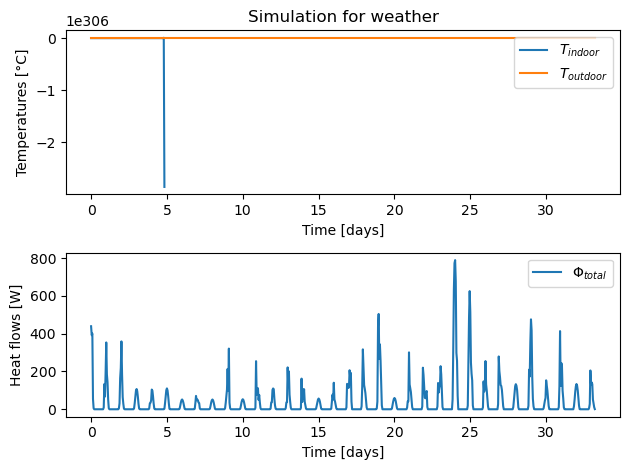

In [38]:
θ_exp = 10 * np.ones([As.shape[0], u.shape[0]])    #10 as inital outside temp

for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]
        
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])



t = dt * np.arange(data.shape[0])   # time vector



fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [days]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')
#the inside temperatur is greatly based on dthe absorbtivity of the wood



# plot total solar radiation and HVAC heat flow
#axs[1].plot(t / 3600 / 24,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [days]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')



fig.tight_layout()

## The calculation of the implicit method

In [39]:
θ_imp = 20 * np.ones([As.shape[0], u.shape[0]])    #20 as inital inside temp
# with 10, there is a huge step of the inside temp and the q_HVAC starts out at about 100'000



for k in range(u.shape[0] - 1):
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u.iloc[k, :])
        
y_imp = Cs @ θ_imp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_imp[0, :])



t = dt * np.arange(data.shape[0])   # time vector


### Plotting data

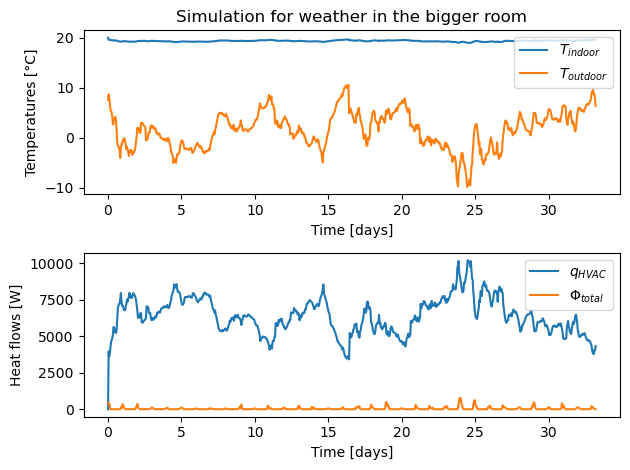

In [41]:
fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature of the big room
axs[0].plot(t / 3600 / 24, y_imp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [days]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather in the bigger room')
axs[0].legend(loc='upper right')
#the inside temperature is always close to 20°C from the HVAC


# plot total solar radiation and HVAC heat flow

axs[1].plot(t / 3600 / 24,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [days]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()


Indoor temperature of the large room is always close to 20°C and only fluctuat only a little bit based on the outdoor temperature. The starting temperatur was already chosen at 20°C.
Q-HVAC is the highest at low outdoor temperatures. This can be seen by comparing the two plots.


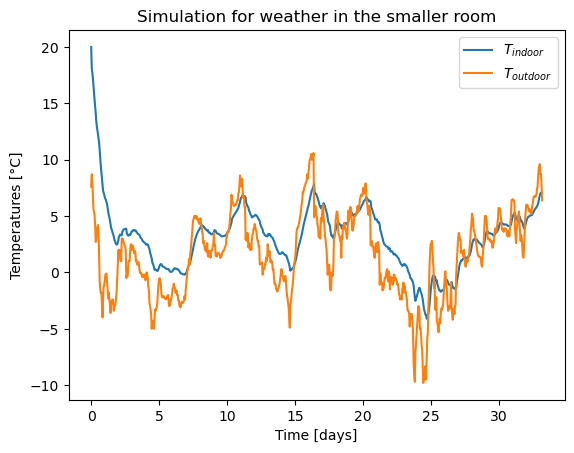

In [42]:
# plot indoor and outdore temp for the smaller room
fig, ax = plt.subplots()
ax.plot(t / 3600 / 24, y_imp[1, :], label='$T_{indoor}$')
ax.plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
ax.set(xlabel='Time [days]',
       ylabel='Temperatures [°C]',
       title='Simulation for weather in the smaller room')
ax.legend(loc='upper right')
plt.show()

Plot data from the temperatur outdoor and temperatur indoor (unheated room)
We can see, the indoor temperature is mostly higher then the outdoor. This is because of the heated room (next to this one).
The starting temperature was also chosen at 20°C and drops down at the beginning. 


# Conclusion
That's the calculation of the two-room-house. It has one room heated with a HVAC-System and the second room is only heated from the first room. 

## Improvments
- If it were necassary for the second room to be a bit warmer, there could be insulation added to the second room and the insulation between the rooms could be made smaller or left out. This would result in a higher heat flow of the HVAC-system.

- If small conductences would be put to zero, the timesteps could be longer. There would be less calculations and the problems of the explicit euler wouldn't be that apparent.
